##### Links to all Kaggle Datasets, and API suppliers used
###### Air quality in Madrid - https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid
###### World AQI by City - https://www.kaggle.com/datasets/adityaramachandran27/world-air-quality-index-by-city-and-coordinates
###### Open-meteo API - https://open-meteo.com


In [164]:
# Import Libraries

import requests
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

## Finding a Correlation between AQ and Temperature in August of Madrid, 2001-2017

In [165]:
# Defining a function which makes an API call to retrieve temperature data for later use

def retrieveDailyMeanTemp(lat, long, start, end):
    response = requests.get(f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={long}&start_date={start}&end_date={end}&daily=temperature_2m_max&timezone=Europe%2FLondon")
    list1 = response.json()["daily"]["time"]
    list2 = response.json()["daily"]["temperature_2m_max"]
    df = pd.DataFrame(list(zip(list1, list2)), columns =['Date', 'Mean Temperature (Degrees Celsius)'])
    df["Date"] = pd.to_datetime(df["Date"])
    return df

### Visualising Madrid PM10 levels overtime

In [166]:
madrid_PM10_df = pd.read_csv("../datasheets/Madrid/Madrid_AVG_PM10_Levels.csv")
madrid_PM10_df.head()

,YEAR,AVG_PM10
0,2001,37.109608
1,2002,31.138318
2,2003,39.133485
3,2004,29.669498
4,2005,38.804536


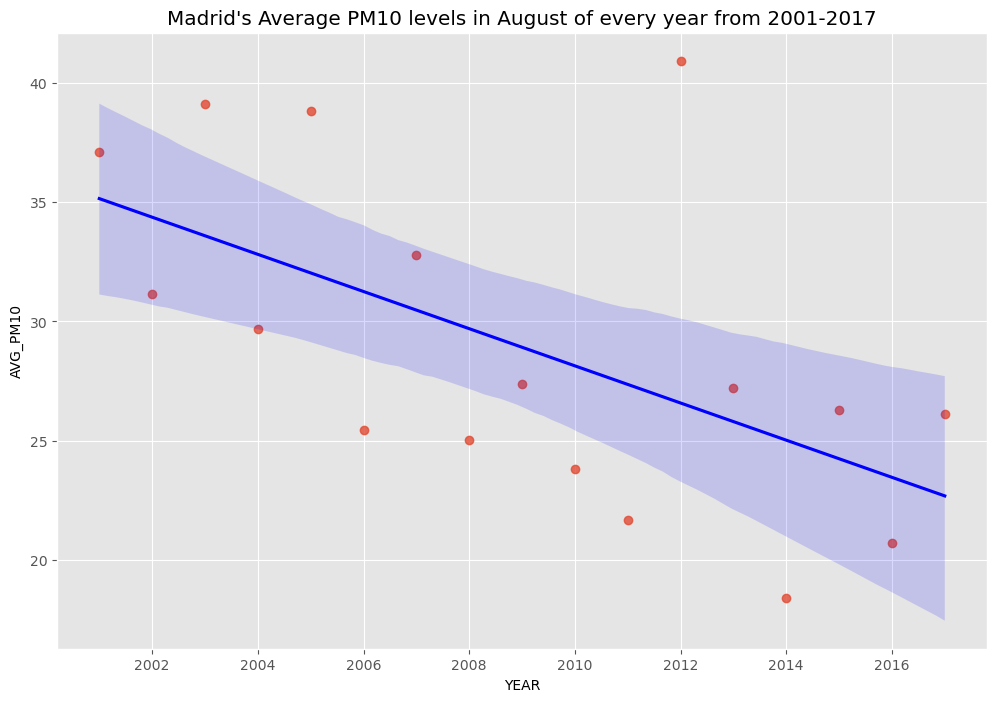

In [167]:
madrid_PM10VsTimeRegLine = sns.regplot(x="YEAR", y="AVG_PM10", data=madrid_PM10_df, line_kws={"color": "blue"}).set(title="Madrid's Average PM10 levels in August of every year from 2001-2017")

###### Average PM10 levels show a downward regression overtime in August of every year from 2001-2017, suggesting that overtime, AQ has increased.

### Visualising Madrid Temperature levels overtime

In [168]:
madrid_Temp_df = retrieveDailyMeanTemp("-3.75", "40.42", "2001-08-01", "2017-08-31")
madrid_Temp_df.head()

,Date,Mean Temperature (Degrees Celsius)
0,2001-08-01,24.5
1,2001-08-02,24.7
2,2001-08-03,24.4
3,2001-08-04,24.3
4,2001-08-05,24.5


In [169]:
madrid_Temp_df_AUG = madrid_Temp_df[(madrid_Temp_df["Date"].dt.month == 8)]
madrid_yearly_Temps = madrid_Temp_df_AUG.groupby(madrid_Temp_df_AUG["Date"].dt.year).mean()
madrid_yearly_Temps = madrid_yearly_Temps.reset_index()
madrid_yearly_Temps = madrid_yearly_Temps.rename(columns={"Date" : "Year"})
madrid_yearly_Temps.head()

C:\Users\eirfa\AppData\Local\Temp\ipykernel_10556\3378281785.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  madrid_yearly_Temps = madrid_Temp_df_AUG.groupby(madrid_Temp_df_AUG["Date"].dt.year).mean()


,Year,Mean Temperature (Degrees Celsius)
0,2001,24.858065
1,2002,25.038710
2,2003,24.854839
3,2004,24.906452
4,2005,25.103226


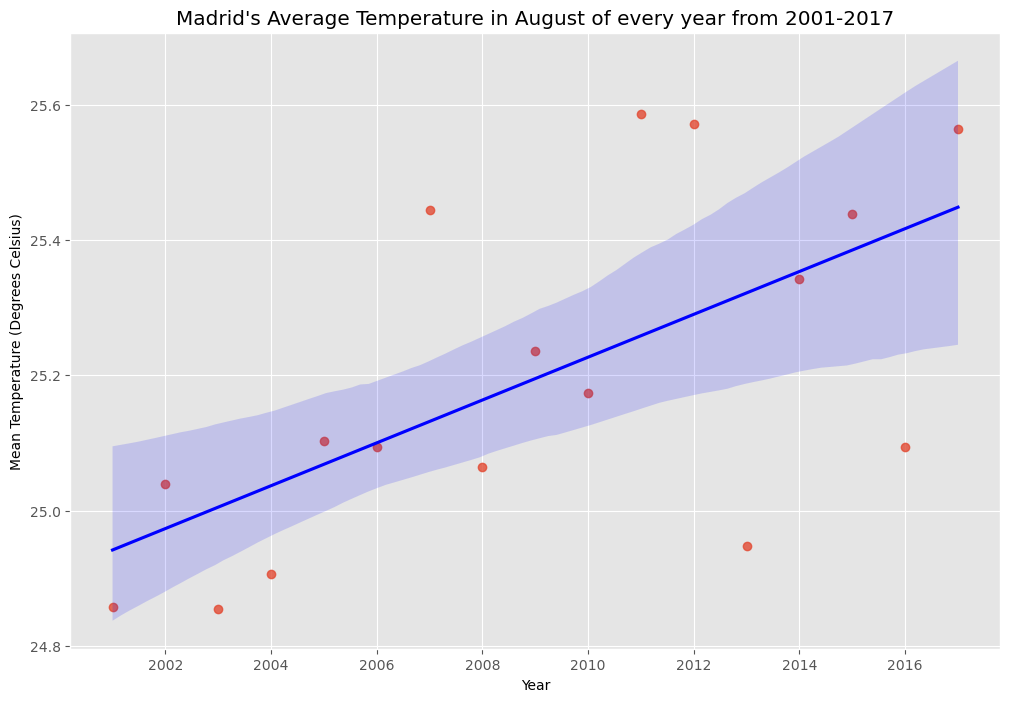

In [170]:
madrid_TempVsTimeRegLine = sns.regplot(x="Year", y="Mean Temperature (Degrees Celsius)", data=madrid_yearly_Temps, line_kws={"color": "blue"}).set(title="Madrid's Average Temperature in August of every year from 2001-2017")

###### Average Temp levels show an upward regression overtime in August of every year from 2001-2017, suggesting that overtime, Temperature has increased.

### Checking for a Relationship between Temperature and Air Quality

In [171]:
madrid_Temp_PM10 = pd.concat([madrid_yearly_Temps, madrid_PM10_df], axis=1)
madrid_Temp_PM10 = madrid_Temp_PM10.drop(["YEAR"], axis="columns")
madrid_Temp_PM10.head()

,Year,Mean Temperature (Degrees Celsius),AVG_PM10
0,2001,24.858065,37.109608
1,2002,25.038710,31.138318
2,2003,24.854839,39.133485
3,2004,24.906452,29.669498
4,2005,25.103226,38.804536


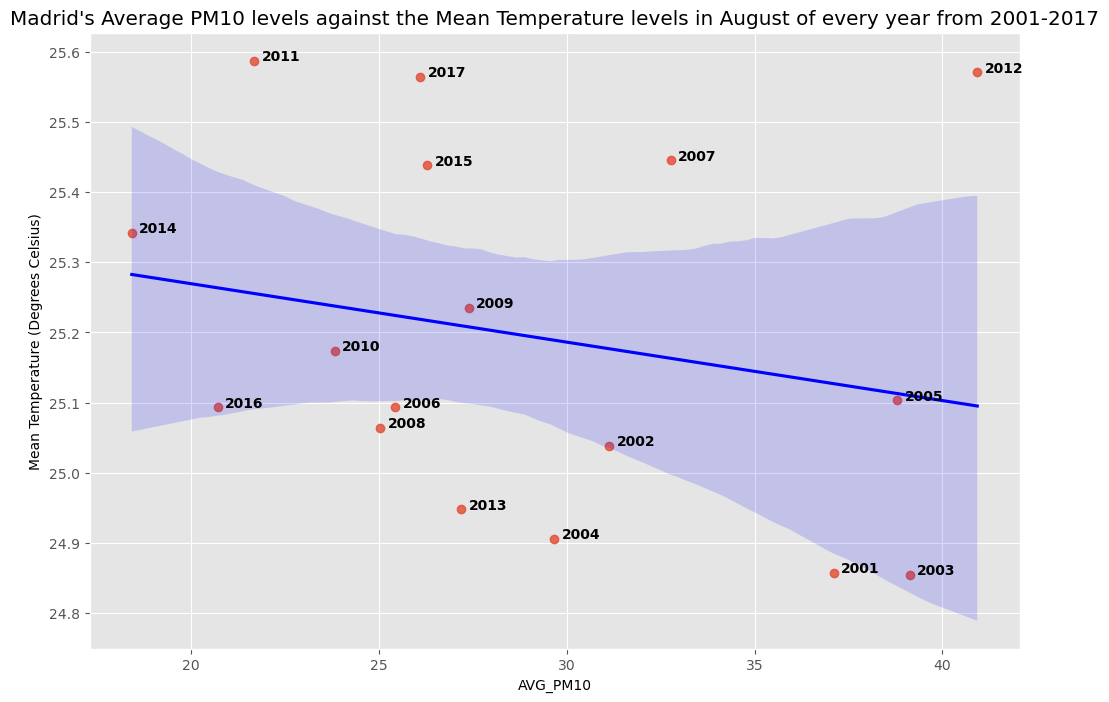

In [172]:
madrid_PM10VsTempRegLine = sns.regplot(x="AVG_PM10", y="Mean Temperature (Degrees Celsius)", data=madrid_Temp_PM10, line_kws={"color": "blue"}).set(title="Madrid's Average PM10 levels against the Mean Temperature levels in August of every year from 2001-2017")

for line in range(0, madrid_Temp_PM10.shape[0]):
     plt.text(madrid_Temp_PM10["AVG_PM10"][line]+0.2, 
              madrid_Temp_PM10["Mean Temperature (Degrees Celsius)"][line], 
              madrid_Temp_PM10["Year"][line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

###### There is not a very strong correlation between Average PM10 levels and Mean Temperature levels in August of every year from 2001-2017 in Madrid. However, there is a small downards regression, suggesting that when PM10 levels increase, temperature should decrease. This could, however be false, because correlation does not imply causation, and many other factors are involved, such as Madrid being relatively developed, allowing for the city to use technology that decreases the amount of air pollution, while still suffering from the affects of climate change. Therefore, these results cannot produce any significant colcusions. To draw a significant conclusion about the relationship between PM10 levels and Temperature, the two must be compared in isolation of other potential factors, and larger datasets, with data from a multitude of cities and countries, all with varying degrees of technological development, must be used.

## Looking average air quality levels across the world

In [173]:
AQI_df = pd.read_csv("../datasheets/AQI_Desired_Columns.csv")

In [174]:
AQI_Category_Country = AQI_df.drop(["City", "AQI Value", "lat", "lng"], axis="columns")
AQI_Category_Country = AQI_Category_Country.groupby(["Country"])["AQI Category"].agg(pd.Series.mode).to_frame().reset_index()
AQI_Category_Country = AQI_Category_Country.rename(columns={"AQI Category" : "Modal AQI Category"})
AQI_Category_Country["Modal AQI Category"] = AQI_Category_Country["Modal AQI Category"].astype("string")
for x in AQI_Category_Country["Modal AQI Category"]:
    if "[" in x:
        a, b = x.split("' '")
        newCategory = b[:-2] + " - " + a[2:]
        AQI_Category_Country["Modal AQI Category"] = AQI_Category_Country["Modal AQI Category"].replace(x, newCategory)
AQI_Category_Country["Modal AQI Category"].unique()

<StringArray>
[                                 'Moderate',
                                      'Good',
                                 'Unhealthy',
                           'Moderate - Good',
            'Unhealthy for Sensitive Groups',
 'Unhealthy for Sensitive Groups - Moderate',
                                 'Hazardous',
                      'Unhealthy - Moderate']
Length: 8, dtype: string

In [175]:
AQI_Category_City_Counts = AQI_df["AQI Category"].value_counts().to_frame().reset_index()
AQI_Category_City_Counts = AQI_Category_City_Counts.rename(columns={"AQI Category" : "Count"})
AQI_Category_City_Counts = AQI_Category_City_Counts.rename(columns={"index" : "AQI Category of Cities"})
AQI_Category_City_Counts.head()

,AQI Category of Cities,Count
0,Good,6497
1,Moderate,5788
2,Unhealthy,767
3,Unhealthy for Sensitive Groups,735
4,Very Unhealthy,120


In [176]:
AQI_Category_Country_Counts = AQI_Category_Country["Modal AQI Category"].value_counts().to_frame().reset_index()
AQI_Category_Country_Counts = AQI_Category_Country_Counts.rename(columns={"Modal AQI Category" : "Count"})
AQI_Category_Country_Counts = AQI_Category_Country_Counts.rename(columns={"index" : "Modal AQI Category of Countries"})
AQI_Category_Country_Counts

,Modal AQI Category of Countries,Count
0,Moderate,75
1,Good,68
2,Unhealthy,13
3,Unhealthy for Sensitive Groups,9
4,Moderate - Good,5
5,Unhealthy for Sensitive Groups - Moderate,2
6,Hazardous,1
7,Unhealthy - Moderate,1


<Axes: xlabel='AQI Category of Cities', ylabel='Count'>

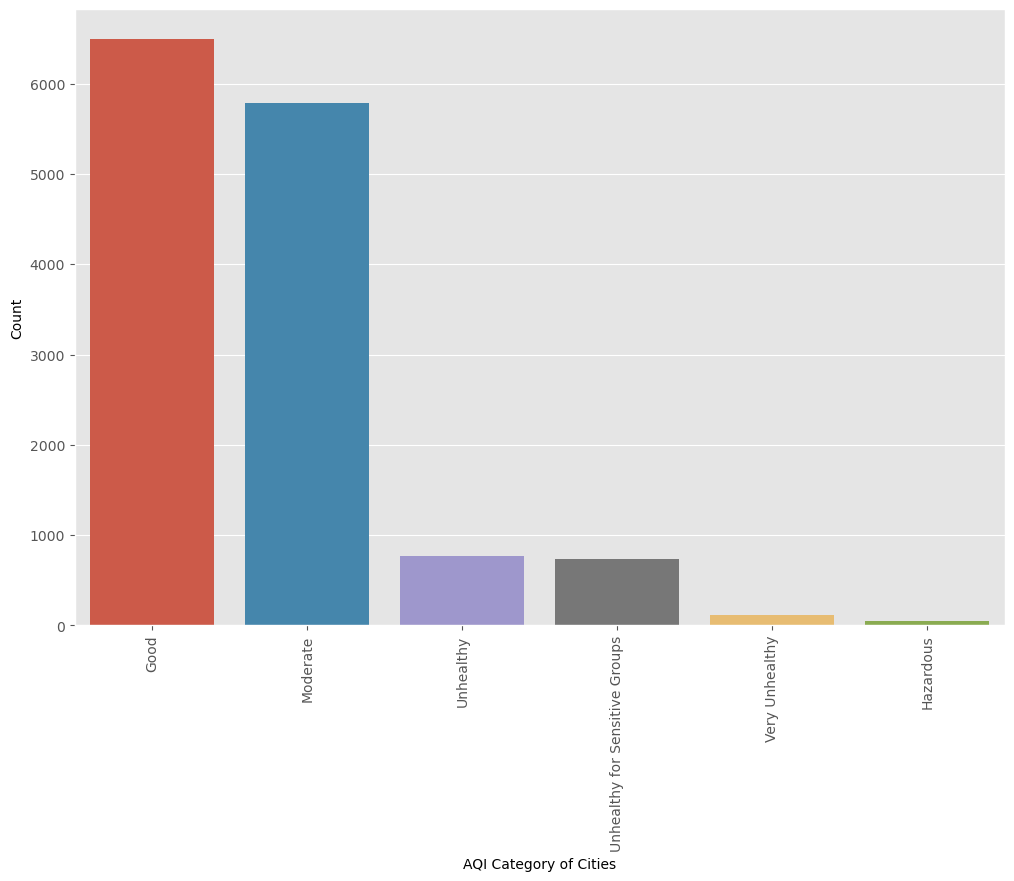

In [208]:
AQI_Category_City_Counts_Barplot = sns.barplot(data=AQI_Category_City_Counts, x="AQI Category of Cities", y="Count")
AQI_Category_City_Counts_Barplot.set_xticklabels(AQI_Category_City_Counts_Barplot.get_xticklabels(), rotation=90)
AQI_Category_City_Counts_Barplot

<Axes: xlabel='Modal AQI Category of Countries', ylabel='Count'>

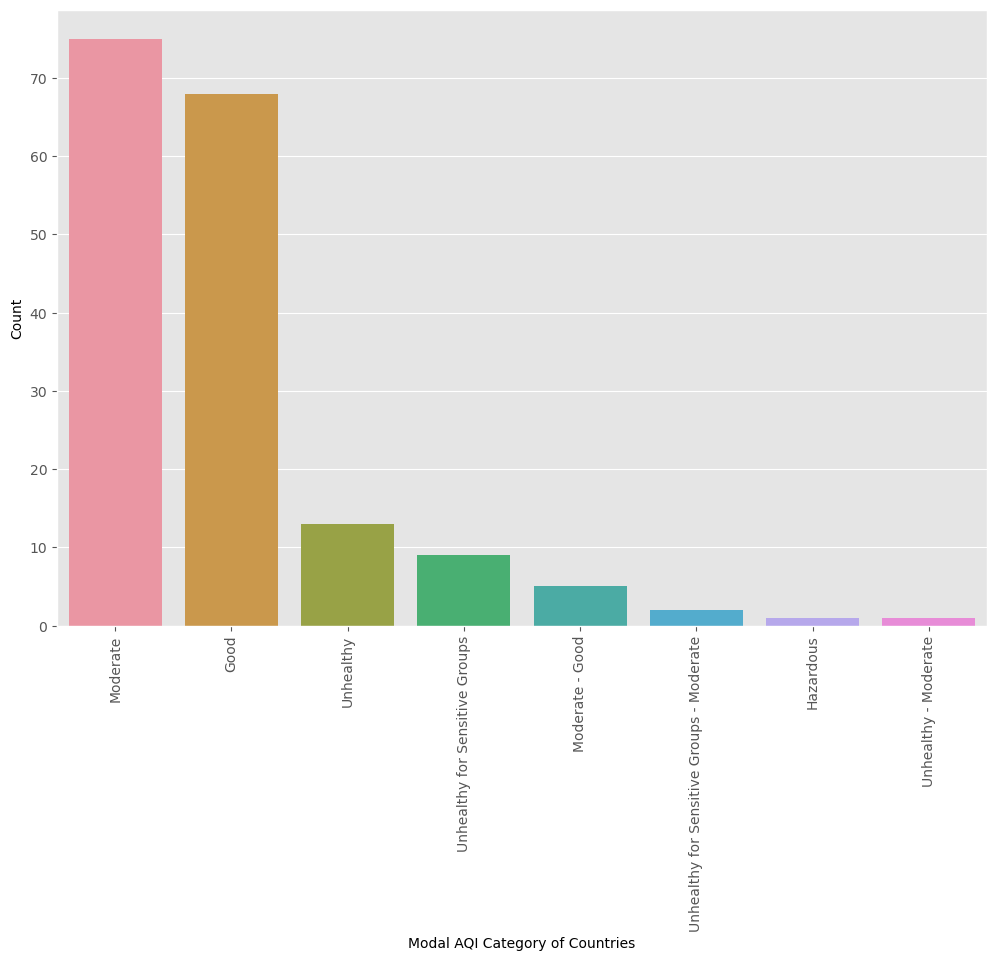

In [211]:
AQI_Category_Country_Counts_Barplot = sns.barplot(data=AQI_Category_Country_Counts, x="Modal AQI Category of Countries", y="Count")
AQI_Category_Country_Counts_Barplot.set_xticklabels(AQI_Category_Country_Counts_Barplot.get_xticklabels(), rotation=90)
AQI_Category_Country_Counts_Barplot

###### Most Cities have good AQI, while most Countries have a mode of Moderate AQI